In [11]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/deep_learning/")
os.chdir("./sentiment_classification")
!ls

gpg: keybox '/tmp/tmp0ey6_771/pubring.gpg' created
gpg: /tmp/tmp0ey6_771/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
bow-cnn.hdf5		       output
count_vectorizer_weights.hdf5  polar.vocab
data			       Sentiment Analysis BOW-CNN.ipynb
data_stopwords		       Sentiment Analysis BOW_MLP-n-grams.ipynb
drive			       Sentiment Classification v1.ipynb
mlpv2.py


### Cleaning code does the following

> convert everything to lower case

> handle negations (convert "don't" to "do not")

> remove tokens that are not alphabetic

> filter stop words

> remove tokens less than 1 character



In [4]:
from string import punctuation
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import re

import nltk
nltk.download('stopwords')

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

def clean(text):
	# split into words without punctuation
	# there's becomes "there" "s"
	tokens = tokenizer.tokenize(text)
	# convert to lower case
	tokens = [w.lower() for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	tokens = [word for word in tokens if not word in stop_words]
	# filter out words less than 1 character
	tokens = [word for word in tokens if len(word) > 1]
	return tokens


negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def cleanv2(text):
	# convert to lower case
	text = text.lower()
	# change don't to do not, doesn't to does not
	text = neg_pattern.sub(lambda x: negations_dic[x.group()], text)
	# remove remaining tokens that are not alphabetic
	text = re.sub("[^a-zA-Z]", " ", text)
	# tokenize
	tokens = tokenizer.tokenize(text)
	# filter out stop words
	tokens = [word for word in tokens if not word in stop_words]
	# filter out words less than 1 character
	tokens = [word for word in tokens if len(word) > 1]
	return tokens	

# Function to create or fetch vocabulary
def make_vocab(vocabFile,directory='./sample'): #floyd
	vocabExists = os.path.isfile(vocabFile)
	if vocabExists:
		# Read and return vocab
		print("Found vocab file {}").format(vocabFile)
		vocab = load_doc(vocabFile)
		vocab = vocab.split('\n')
		print("Vocabulary has {} words").format(len(vocab))
	else:
		print("Did not find vocab file {}").format(vocabFile)
		vocab = Counter()
		# walk through all files in the folder
		for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load and clean the doc
				doc = load_doc(filepath)
				tokens = cleanv2(doc)
				vocab.update(tokens)

		print("Number of tokens before filtering freqeuncy of occurance: {}").format(len(vocab))
		vocab = [word for word,freq in vocab.most_common() if freq>2]
		print("Number of tokens occuring more than 2 times: {}").format(len(vocab))
		
		# Save the vocabulary file
		# convert lines to a single blob of text
		data = '\n'.join(vocab)
		# open file
		file = open(vocabFile, 'w+')
		# write text
		print("Saving vocabulary to {}").format(vocabFile)
		file.write(data)
		# close file
		file.close()
	return vocab


# change all files to BoW representation 
# based on frequency of words in each review
# load all docs in a directory into memory
def process_reviews(directory,vocab):
	reviews = list()
	sentiment = list()
	# walk through all files in the folder
	for path, subdirs, files in os.walk(directory):
			for filename in files:
				# create the full path of the file to open
				filepath =  os.path.join(path, filename)
				# load the doc
				doc = load_doc(filepath)
				# clean doc
				tokens = cleanv2(doc)
				# filter by vocab
				tokens = [word for word in tokens if word in vocab]
				review = ' '.join(tokens)
				# append review to reviews
				reviews.append(review)
				# Get the sentiment as well
				sentiment.append(1 if 'pos' in filepath else 0)

	return reviews,sentiment


def get_data(data_file,isTrain=True):
	dataset_type = 'train' if isTrain else 'test'
	if os.path.isfile(data_file):
		print("Found "+dataset_type+" File {}.").format(data_file)
		data = pickle.load(open(data_file, 'rb'))
		X,y = zip(*data)


	else:
		print("Did not find "+dataset_type+" file.")
		vocab = make_vocab('./polar.vocab','./dataset/train')#floyd
		print("Saved Vocabulary")
		print("processing reviews...")
		X,y = process_reviews('./dataset/'+dataset_type,vocab) #floyd
		data = zip(np.array(X),np.array(y))
		np.array(data).dump('./output/'+dataset_type+'.data') #floyd

	X = np.array(X)
	y = np.array(y)
	print("Found {} samples for "+dataset_type).format(X.shape[0])

	return X,y

def ngram_tokenize(X_train,X_test,max_features=None,ngram=(1,1)):
  from sklearn.feature_extraction.text import CountVectorizer
  vectorizer = CountVectorizer(analyzer = "word", 
                               ngram_range = ngram,
                               binary=False, # If True it is frequency else binary
                               max_features = max_features) 
  vectorizer.fit(X_train)
  X_train = vectorizer.transform(X_train)
  X_test = vectorizer.transform(X_test)
  #print vectorizer.vocabulary_
  return X_train,X_test


def get_model(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout

	input_layer = Input(shape=(input_shape,))
	x = Dense(50,activation='relu')(input_layer)
	x = Dropout(0.5)(x)
	# x = Dense(128,activation='relu')(x)
	# x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()
	return model


def train_model(model, X,y,epochs=10):
	from keras.callbacks import ModelCheckpoint
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=30)
	save_model = ModelCheckpoint('count_vectorizer_weights.hdf5', monitor='val_loss',save_best_only=True) #floyd
	hist = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=1, callbacks=[save_model],validation_data=(X_val,y_val),shuffle=True )
	return hist

def test_model(model, X_test, y_test):
	print("Testing model on {}").format(X_test.shape[0])
	model.load_weights('count_vectorizer_weights.hdf5') #floyd
	loss, acc = model.evaluate(X_test, y_test, verbose=0)
	print('Test Accuracy: %f' % (acc*100))

def plot_loss(hist):
	import matplotlib.pyplot as plt
	loss = hist.history['loss'] #np.loadtxt('my_cnn_model_loss.csv')
	val_loss = hist.history['val_loss'] #np.loadtxt('my_cnn_model_val_loss.csv')

	plt.plot(loss, linewidth=3, label='train')
	plt.plot(val_loss, linewidth=3, label='valid')
	plt.grid()
	plt.legend()
	plt.xlabel('epoch')
	plt.ylabel('loss')
	#plt.ylim(1e-3, 1e-2)
	plt.yscale('log')
	plt.show()


[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Using all the trigrams with 50 hidden layer neurons

In [0]:
train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=None,ngram=(3,3))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
(25000, 2741357)
(25000, 2741357)


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2741357)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                137067900 
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 137,067,951
Trainable params: 137,067,951
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 765s - loss: 0.5818 - acc: 0.6936 - val_loss: 0.4718 - val_acc: 0.7760
Epoch 2/10
 - 767s - loss: 0.0261 - acc: 0.9958 - val_loss: 0.4616 - val_acc: 0.7730
Epoch 3/10
 - 766s - loss: 0.0029 - acc: 

In [6]:
test_model(model,X_test,y_test)


Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Using TensorFlow backend.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2741357)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                137067900 
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 137,067,951
Trainable params: 137,067,951
Non-trainable params: 0
_________________________________________________________________
Testing model on 25000
Test Accuracy: 74.984000


### Using top 50000 trigrams with 50 hidden layer neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test


{u'country old men': 12432, u'enjoy years come': 14811, u'kiki delivery service': 23933, u'movie waiting something': 30708, u'three times two': 44396, u'one point another': 33565, u'could better written': 12206, u'laugh male strangers': 25028, u'real could feel': 36539, u'film gives film': 17394, u'making movie movie': 27515, u'assassinate president united': 2231, u'comedy tragedy film': 11711, u'best tv shows': 3315, u'self promotion br': 40056, u'hell rests night': 22172, u'get back believe': 19877, u'many good horror': 27778, u'movie watch movies': 30744, u'br br laughed': 5455, u'would really want': 49452, u'could br br': 12208, u'wife suzanne lara': 48655, u'wrong reasons br': 49621, u'one films really': 33337, u'extremely well crafted': 15990, u'hard watch one': 21893, u'whole movie takes': 48444, u'first film really': 18415, u'manager jack oakie': 27627, u'movie way back': 30768, u'comedic acting slow': 11656, u'art direction editing': 2148, u'uniformed police officer': 46307, u

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 689us/step - loss: 0.5944 - acc: 0.6765 - val_loss: 0.4925 - val_acc: 0.7608
Epoch 2/10
20000/20000 [==============================] - 13s 649us/step - loss: 0.3147 - acc: 0.8706 - val_loss: 0.4815 - val_acc: 0.7700
Epoch 3/10
 2112/20000 [==>...........................] - ETA: 10s - loss: 0.1593 - acc: 0.9527

20000/20000 [==============================] - 12s 619us/step - loss: 0.1716 - acc: 0.9353 - val_loss: 0.5360 - val_acc: 0.7736
Epoch 4/10
20000/20000 [==============================] - 12s 611us/step - loss: 0.1054 - acc: 0.9597 - val_loss: 0.6106 - val_acc: 0.7670
Epoch 5/10
11296/20000 [===============>..............] - ETA: 4s - loss: 0.0737 - acc: 0.9740

20000/20000 [==============================] - 12s 620us/step - loss: 0.0762 - acc: 0.9718 - val_loss: 0.6806 - val_acc: 0.7642
Epoch 6/10
20000/20000 [==============================] - 12s 612us/step - loss: 0.0583 - acc: 0.9759 - val_loss: 0.7484 - val_acc: 0.7582
Epoch 7/10
13184/20000 [==================>...........] - ETA: 3s - loss: 0.0486 - acc: 0.9779

20000/20000 [==============================] - 12s 613us/step - loss: 0.0500 - acc: 0.9773 - val_loss: 0.8090 - val_acc: 0.7544
Epoch 8/10
20000/20000 [==============================] - 12s 615us/step - loss: 0.0427 - acc: 0.9787 - val_loss: 0.8720 - val_acc: 0.7470
Epoch 9/10
13792/20000 [===================>..........] - ETA: 3s - loss: 0.0379 - acc: 0.9819

20000/20000 [==============================] - 12s 618us/step - loss: 0.0384 - acc: 0.9809 - val_loss: 0.9244 - val_acc: 0.7474
Epoch 10/10
20000/20000 [==============================] - 12s 603us/step - loss: 0.0363 - acc: 0.9800 - val_loss: 0.9774 - val_acc: 0.7528
Testing model on 25000
Test Accuracy: 71.144000


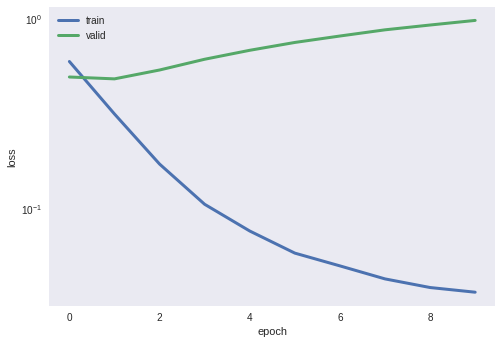

In [8]:
train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=500000,ngram=(3,3))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using top 50000 trigrams with 500 hidden layer neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
(25000, 50000)
(25000, 50000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               25000500  
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 25,001,001
Trainable params: 25,001,001
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 5216/20000 [======>.......................

20000/20000 [==============================] - 28s 1ms/step - loss: 0.5565 - acc: 0.7026 - val_loss: 0.4729 - val_acc: 0.7750
Epoch 2/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.2333 - acc: 0.8973 - val_loss: 0.5541 - val_acc: 0.7684
Epoch 3/10
 1376/20000 [=>............................] - ETA: 24s - loss: 0.0912 - acc: 0.9637

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0907 - acc: 0.9603 - val_loss: 0.7151 - val_acc: 0.7620
Epoch 4/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0497 - acc: 0.9752 - val_loss: 0.8311 - val_acc: 0.7506
Epoch 5/10
 1056/20000 [>.............................] - ETA: 24s - loss: 0.0386 - acc: 0.9763

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0363 - acc: 0.9788 - val_loss: 0.9383 - val_acc: 0.7556
Epoch 6/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0337 - acc: 0.9802 - val_loss: 1.0088 - val_acc: 0.7528
Epoch 7/10
  864/20000 [>.............................] - ETA: 25s - loss: 0.0248 - acc: 0.9850

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0307 - acc: 0.9809 - val_loss: 1.0697 - val_acc: 0.7460
Epoch 8/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0311 - acc: 0.9816 - val_loss: 1.1225 - val_acc: 0.7428
Epoch 9/10
  928/20000 [>.............................] - ETA: 24s - loss: 0.0273 - acc: 0.9828

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0290 - acc: 0.9821 - val_loss: 1.1751 - val_acc: 0.7470
Epoch 10/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.0291 - acc: 0.9820 - val_loss: 1.2100 - val_acc: 0.7390
Testing model on 25000
Test Accuracy: 72.132000


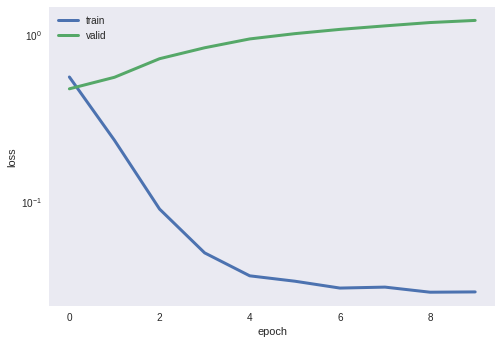

In [7]:
def get_model(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout

	input_layer = Input(shape=(input_shape,))
	x = Dense(500,activation='relu')(input_layer)
	x = Dropout(0.5)(x)
	#x = Dense(128,activation='relu')(x)
	#x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()
	return model

train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=50000,ngram=(3,3))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using top 50000 trigrams with 5000 hidden layer neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test


{u'country old men': 12432, u'enjoy years come': 14811, u'kiki delivery service': 23933, u'movie waiting something': 30708, u'three times two': 44396, u'one point another': 33565, u'could better written': 12206, u'laugh male strangers': 25028, u'real could feel': 36539, u'film gives film': 17394, u'making movie movie': 27515, u'assassinate president united': 2231, u'comedy tragedy film': 11711, u'best tv shows': 3315, u'self promotion br': 40056, u'hell rests night': 22172, u'get back believe': 19877, u'many good horror': 27778, u'movie watch movies': 30744, u'br br laughed': 5455, u'would really want': 49452, u'could br br': 12208, u'wife suzanne lara': 48655, u'wrong reasons br': 49621, u'one films really': 33337, u'extremely well crafted': 15990, u'hard watch one': 21893, u'whole movie takes': 48444, u'first film really': 18415, u'manager jack oakie': 27627, u'movie way back': 30768, u'comedic acting slow': 11656, u'art direction editing': 2148, u'uniformed police officer': 46307, u

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5000)              250005000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5001      
Total params: 250,010,001
Trainable params: 250,010,001
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 3072/20000 [===>..........................] - ETA: 3:10 - loss: 0.6535 - acc: 0.5993

20000/20000 [==============================] - 202s 10ms/step - loss: 0.5500 - acc: 0.7061 - val_loss: 0.4692 - val_acc: 0.7710
Epoch 2/10
 7840/20000 [==========>...................] - ETA: 2:00 - loss: 0.1960 - acc: 0.9165

20000/20000 [==============================] - 199s 10ms/step - loss: 0.2108 - acc: 0.9067 - val_loss: 0.5962 - val_acc: 0.7602
Epoch 3/10
 9664/20000 [=============>................] - ETA: 1:40 - loss: 0.0670 - acc: 0.9715

20000/20000 [==============================] - 198s 10ms/step - loss: 0.0685 - acc: 0.9696 - val_loss: 0.8364 - val_acc: 0.7540
Epoch 4/10
10336/20000 [==============>...............] - ETA: 1:33 - loss: 0.0390 - acc: 0.9790

20000/20000 [==============================] - 198s 10ms/step - loss: 0.0385 - acc: 0.9782 - val_loss: 0.9824 - val_acc: 0.7530
Epoch 5/10
10592/20000 [==============>...............] - ETA: 1:31 - loss: 0.0352 - acc: 0.9791

20000/20000 [==============================] - 198s 10ms/step - loss: 0.0323 - acc: 0.9796 - val_loss: 1.0894 - val_acc: 0.7434
Epoch 6/10
10688/20000 [===============>..............] - ETA: 1:30 - loss: 0.0283 - acc: 0.9818

20000/20000 [==============================] - 198s 10ms/step - loss: 0.0304 - acc: 0.9811 - val_loss: 1.1637 - val_acc: 0.7378
Epoch 7/10
10720/20000 [===============>..............] - ETA: 1:29 - loss: 0.0278 - acc: 0.9828

20000/20000 [==============================] - 198s 10ms/step - loss: 0.0294 - acc: 0.9820 - val_loss: 1.2049 - val_acc: 0.7388
Epoch 8/10
10752/20000 [===============>..............] - ETA: 1:29 - loss: 0.0309 - acc: 0.9799

20000/20000 [==============================] - 198s 10ms/step - loss: 0.0292 - acc: 0.9819 - val_loss: 1.2489 - val_acc: 0.7428
Epoch 9/10
10752/20000 [===============>..............] - ETA: 1:29 - loss: 0.0291 - acc: 0.9823

20000/20000 [==============================] - 197s 10ms/step - loss: 0.0291 - acc: 0.9823 - val_loss: 1.2803 - val_acc: 0.7382
Epoch 10/10
10720/20000 [===============>..............] - ETA: 1:29 - loss: 0.0305 - acc: 0.9813

20000/20000 [==============================] - 197s 10ms/step - loss: 0.0292 - acc: 0.9814 - val_loss: 1.3131 - val_acc: 0.7422
Testing model on 25000
Test Accuracy: 72.136000


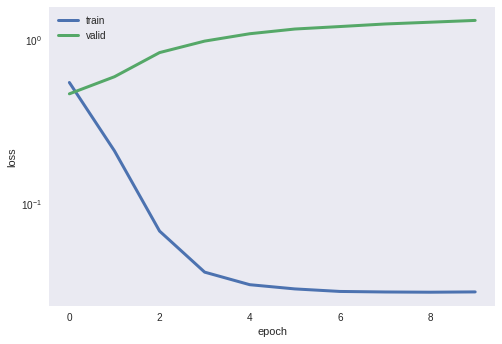

In [4]:
def get_model(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout

	input_layer = Input(shape=(input_shape,))
	x = Dense(5000,activation='relu')(input_layer)
	x = Dropout(0.5)(x)
	#x = Dense(128,activation='relu')(x)
	#x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()
	return model

train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=50000,ngram=(3,3))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using top 6000 trigrams with 50 hidden layer neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
(25000, 6000)
(25000, 6000)


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                300050    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 300,101
Trainable params: 300,101
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 365us/step - loss: 0.6276 - acc: 0.6434 - val_loss: 0.5539 - val_acc: 0.7040
Epoch 2/10
  768/20000 [>.............................] - ETA: 5s - loss: 0.5134 

20000/20000 [==============================] - 5s 264us/step - loss: 0.4937 - acc: 0.7398 - val_loss: 0.5395 - val_acc: 0.7086
Epoch 3/10
20000/20000 [==============================] - 5s 265us/step - loss: 0.4340 - acc: 0.7735 - val_loss: 0.5510 - val_acc: 0.7126
Epoch 4/10
20000/20000 [==============================] - 5s 261us/step - loss: 0.3960 - acc: 0.7957 - val_loss: 0.5761 - val_acc: 0.7100
Epoch 5/10
17632/20000 [=========================>....] - ETA: 0s - loss: 0.3647 - acc: 0.8092

20000/20000 [==============================] - 5s 258us/step - loss: 0.3669 - acc: 0.8084 - val_loss: 0.6021 - val_acc: 0.7068
Epoch 6/10
20000/20000 [==============================] - 5s 259us/step - loss: 0.3430 - acc: 0.8216 - val_loss: 0.6294 - val_acc: 0.7086
Epoch 7/10
20000/20000 [==============================] - 5s 260us/step - loss: 0.3214 - acc: 0.8291 - val_loss: 0.6617 - val_acc: 0.7042
Epoch 8/10
20000/20000 [==============================] - 5s 259us/step - loss: 0.3063 - acc: 0.8395 - val_loss: 0.6984 - val_acc: 0.7020
Epoch 9/10
  480/20000 [..............................] - ETA: 4s - loss: 0.2608 - acc: 0.8646

20000/20000 [==============================] - 5s 259us/step - loss: 0.2859 - acc: 0.8500 - val_loss: 0.7384 - val_acc: 0.6994
Epoch 10/10
20000/20000 [==============================] - 5s 260us/step - loss: 0.2739 - acc: 0.8566 - val_loss: 0.7807 - val_acc: 0.7006
Testing model on 25000
Test Accuracy: 68.948000


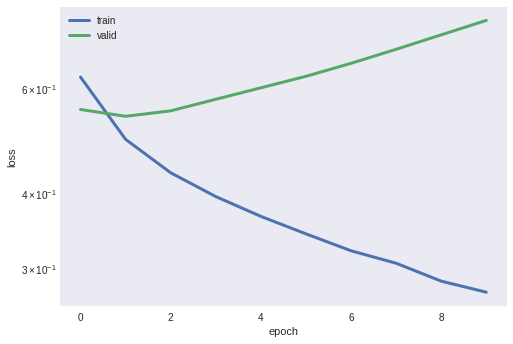

In [5]:
train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=6000,ngram=(3,3))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using top 50000 bigrams and unigrams with 500 neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
(25000, 50000)
(25000, 50000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               25000500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total params: 25,001,001
Trainable params: 25,001,001
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 5184/20000 [======>.......................

20000/20000 [==============================] - 28s 1ms/step - loss: 0.3147 - acc: 0.8729 - val_loss: 0.2691 - val_acc: 0.8942
Epoch 2/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0900 - acc: 0.9688 - val_loss: 0.3547 - val_acc: 0.8860
Epoch 3/10
 1568/20000 [=>............................] - ETA: 24s - loss: 0.0211 - acc: 0.9962

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0209 - acc: 0.9949 - val_loss: 0.4481 - val_acc: 0.8866
Epoch 4/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0053 - acc: 0.9991 - val_loss: 0.4965 - val_acc: 0.8864
Epoch 5/10
 1056/20000 [>.............................] - ETA: 24s - loss: 0.0016 - acc: 1.0000

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.5392 - val_acc: 0.8892
Epoch 6/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.6112 - val_acc: 0.8828
Epoch 7/10
  928/20000 [>.............................] - ETA: 25s - loss: 4.0998e-04 - acc: 1.0000

20000/20000 [==============================] - 28s 1ms/step - loss: 6.0929e-04 - acc: 1.0000 - val_loss: 0.6371 - val_acc: 0.8860
Epoch 8/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 0.7245 - val_acc: 0.8778
Epoch 9/10
  416/20000 [..............................] - ETA: 25s - loss: 4.4314e-04 - acc: 1.0000

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0227 - acc: 0.9941 - val_loss: 0.7831 - val_acc: 0.8838
Epoch 10/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0143 - acc: 0.9959 - val_loss: 0.8299 - val_acc: 0.8788
Testing model on 25000
Test Accuracy: 87.984000


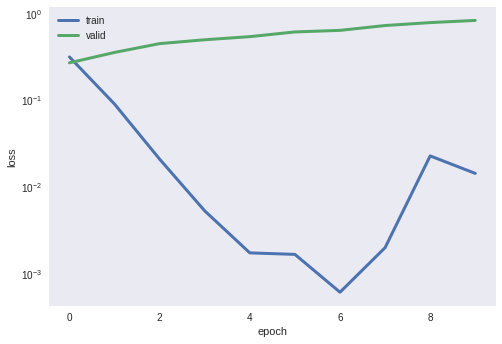

In [6]:
def get_model(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout

	input_layer = Input(shape=(input_shape,))
	x = Dense(500,activation='relu')(input_layer)
	x = Dropout(0.5)(x)
	#x = Dense(128,activation='relu')(x)
	#x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()
	return model

train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=50000,ngram=(1,2))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using top 50000 bigrams with 500 hidden layer neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
(25000, 50000)
(25000, 50000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 50000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 500)               25000500  
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 501       
Total params: 25,001,001
Trainable params: 25,001,001
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 5120/20000 [======>.......................

20000/20000 [==============================] - 28s 1ms/step - loss: 0.4007 - acc: 0.8194 - val_loss: 0.3314 - val_acc: 0.8592
Epoch 2/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0978 - acc: 0.9664 - val_loss: 0.4418 - val_acc: 0.8558
Epoch 3/10
 1568/20000 [=>............................] - ETA: 24s - loss: 0.0154 - acc: 0.9987

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0155 - acc: 0.9968 - val_loss: 0.5478 - val_acc: 0.8556
Epoch 4/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0032 - acc: 0.9994 - val_loss: 0.6138 - val_acc: 0.8560
Epoch 5/10
 1056/20000 [>.............................] - ETA: 24s - loss: 0.0010 - acc: 1.0000    

20000/20000 [==============================] - 27s 1ms/step - loss: 0.0016 - acc: 0.9997 - val_loss: 0.6588 - val_acc: 0.8554
Epoch 6/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.6905 - val_acc: 0.8558
Epoch 7/10
  800/20000 [>.............................] - ETA: 25s - loss: 0.0014 - acc: 1.0000

20000/20000 [==============================] - 28s 1ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 0.7203 - val_acc: 0.8530
Epoch 8/10
20000/20000 [==============================] - 27s 1ms/step - loss: 6.5445e-04 - acc: 0.9998 - val_loss: 0.7976 - val_acc: 0.8402
Epoch 9/10
  544/20000 [..............................] - ETA: 25s - loss: 8.4114e-04 - acc: 1.0000

20000/20000 [==============================] - 27s 1ms/step - loss: 3.1040e-04 - acc: 0.9999 - val_loss: 0.7813 - val_acc: 0.8514
Epoch 10/10
20000/20000 [==============================] - 28s 1ms/step - loss: 2.8094e-04 - acc: 1.0000 - val_loss: 0.8116 - val_acc: 0.8502
Testing model on 25000
Test Accuracy: 83.440000


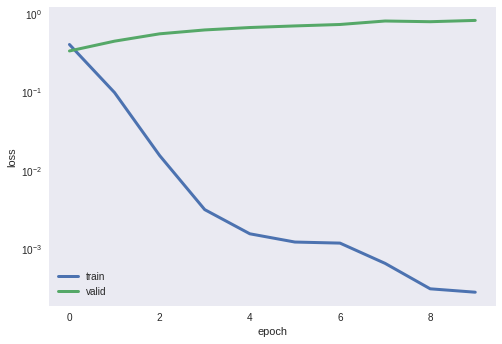

In [9]:
def get_model(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout

	input_layer = Input(shape=(input_shape,))
	x = Dense(500,activation='relu')(input_layer)
	x = Dropout(0.5)(x)
	#x = Dense(128,activation='relu')(x)
	#x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()
	return model

train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=50000,ngram=(2,2))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)

### Using top 37233 unigrams with 500 hidden layer neurons

Found train File ./data/train.data.
Found 25000 samples for train
Found test File ./data/test.data.
Found 25000 samples for test
(25000, 37233)
(25000, 37233)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 37233)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 500)               18617000  
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 501       
Total params: 18,617,501
Trainable params: 18,617,501
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 4832/20000 [======>.......................

20000/20000 [==============================] - 22s 1ms/step - loss: 0.3326 - acc: 0.8649 - val_loss: 0.2890 - val_acc: 0.8894
Epoch 2/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1282 - acc: 0.9541 - val_loss: 0.3506 - val_acc: 0.8804
Epoch 3/10
  800/20000 [>.............................] - ETA: 20s - loss: 0.0480 - acc: 0.9900

20000/20000 [==============================] - 22s 1ms/step - loss: 0.0437 - acc: 0.9876 - val_loss: 0.4193 - val_acc: 0.8798
Epoch 4/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0133 - acc: 0.9976 - val_loss: 0.4927 - val_acc: 0.8792
Epoch 5/10
  160/20000 [..............................] - ETA: 20s - loss: 0.0048 - acc: 1.0000

20000/20000 [==============================] - 22s 1ms/step - loss: 0.0057 - acc: 0.9994 - val_loss: 0.5481 - val_acc: 0.8836
Epoch 6/10
19488/20000 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9997

20000/20000 [==============================] - 22s 1ms/step - loss: 0.0030 - acc: 0.9997 - val_loss: 0.6010 - val_acc: 0.8816
Epoch 7/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0035 - acc: 0.9992 - val_loss: 0.6522 - val_acc: 0.8740
Epoch 8/10
 4384/20000 [=====>........................] - ETA: 16s - loss: 0.0038 - acc: 0.9989

20000/20000 [==============================] - 22s 1ms/step - loss: 0.0087 - acc: 0.9972 - val_loss: 0.7372 - val_acc: 0.8692
Epoch 9/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0128 - acc: 0.9963 - val_loss: 0.7301 - val_acc: 0.8734
Epoch 10/10
 1056/20000 [>.............................] - ETA: 19s - loss: 0.0088 - acc: 0.9981

20000/20000 [==============================] - 22s 1ms/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.7439 - val_acc: 0.8714
Testing model on 25000
Test Accuracy: 87.368000


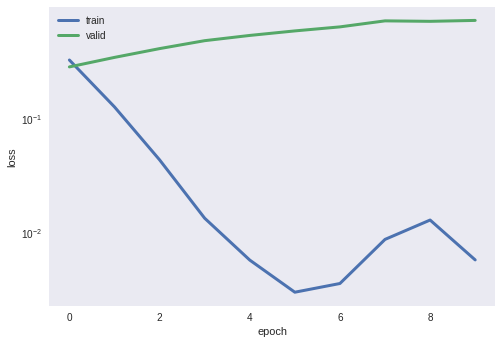

In [10]:
def get_model(input_shape):

	from keras.models import Model
	from keras.layers import Input, Dense, Dropout

	input_layer = Input(shape=(input_shape,))
	x = Dense(500,activation='relu')(input_layer)
	x = Dropout(0.5)(x)
	#x = Dense(128,activation='relu')(x)
	#x = Dropout(0.5)(x)
	output_layer = Dense(1,activation='sigmoid')(x)
	model = Model(inputs=input_layer, outputs=output_layer)

	model.summary()
	return model

train_file = './data/train.data' #floyd
test_file = './data/test.data' #floyd

X,y = get_data(train_file,True)
X_test,y_test = get_data(test_file,False)

X,X_test = ngram_tokenize(X,X_test,max_features=50000,ngram=(1,1))
print(X.shape)
print(X_test.shape)
model = get_model(input_shape=X.shape[1])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = train_model(model,X,y,epochs=10)
test_model(model,X_test,y_test)
plot_loss(hist)